In [6]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

# with open("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/best_of_n_completions.jsonl", "rb") as f:
#     f.seek(0, 2)
#     size_bytes = f.tell()
# print(f"File size: {size_bytes} bytes")
df_train_math500 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv")
df_train_math500.head()

#### Load in Training Data.

In [4]:
# load in combined training data.
import pandas as pd

combined_training_data = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/sl/combined_training_data.csv")
# change the column name from "SL" to "sl".
combined_training_data.rename(columns={"SL": "sl"}, inplace=True)
combined_training_data.head(), combined_training_data.shape

(                                            question  N       method        sl
 0  Through the midpoint \(M\) of side \(BC\) of p...  2  beam_search  0.000000
 1  Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...  2  beam_search  0.000000
 2  Let $a,$ $b,$ $c$ be positive real numbers suc...  2  beam_search  0.433333
 3  Given that the graph of the quadratic function...  2  beam_search  0.600000
 4  Three circles  $\mathcal{K}_1$ ,  $\mathcal{K}...  2  beam_search  1.000000,
 (426617, 4))

In [5]:
combined_training_data["question"].unique().shape

(29862,)

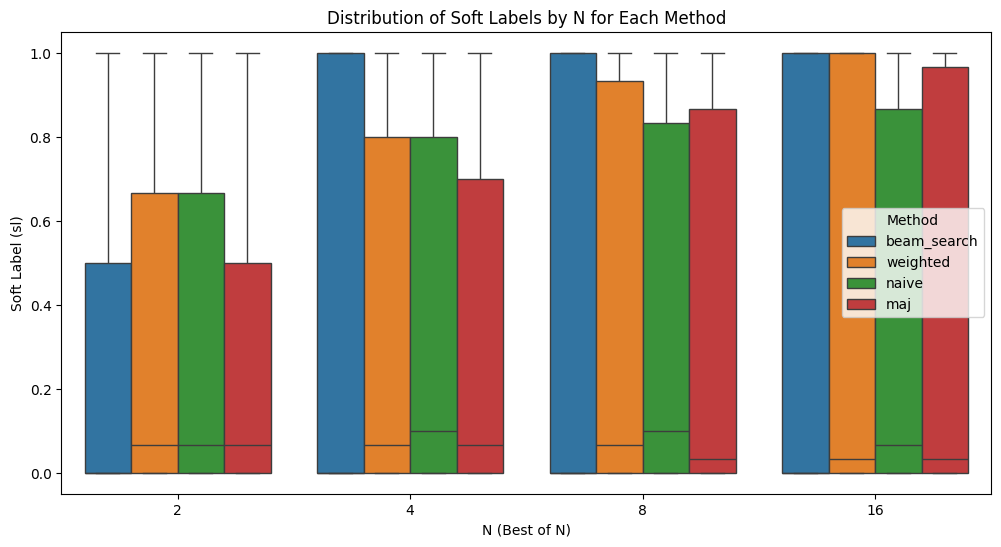

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="N", y="sl", hue="method", data=combined_training_data)
plt.title("Distribution of Soft Labels by N for Each Method")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.legend(title="Method")
plt.show()

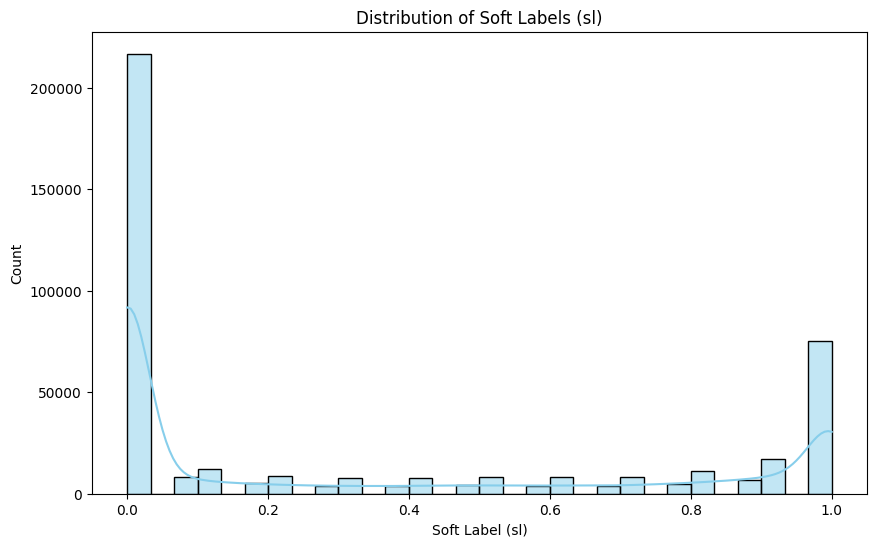

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_training_data["sl"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Soft Labels (sl)")
plt.xlabel("Soft Label (sl)")
plt.ylabel("Count")
plt.show()



In [7]:
combined_training_data.shape, combined_training_data["question"].unique().shape

((426617, 4), (29862,))

Drop questions that are overly difficult (all zeros in all N's)

In [6]:
import sys
import os
sys.path.append('/dccstor/gma2/jhjenny9/search-and-learn/scripts')

# Now you can import
import data_processing.filter_questions

# Drop 80% of questions that have all zeros across all N values
filtered_zeros_df = data_processing.filter_questions.drop_extreme_questions(
    df=combined_training_data,
    target_value=0,        # Target zeros
    min_target_N=3,          # Must have zeros for at least 3 N values
    frac=0.8,                # Drop 80% of eligible questions
    random_state=42          # For reproducible results
)

filtered_df = data_processing.filter_questions.drop_extreme_questions(
    df=filtered_zeros_df,
    target_value=1,        # Target ones
    min_target_N=4,          # Must have ones for at least 5 N values
    frac=0.8,                # Drop 80% of eligible questions
    random_state=42          # For reproducible results
)

In [7]:
filtered_df["question"].unique().shape

(17053,)

We are now left with 15,808 unique questions.
You might think to add back the question so that the model can learn question embeddings better.

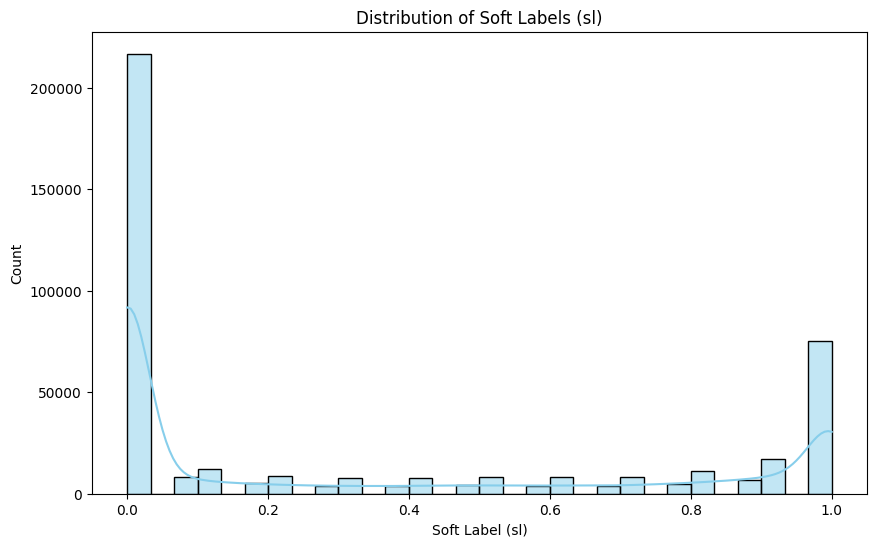

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["sl"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Soft Labels (sl)")
plt.xlabel("Soft Label (sl)")
plt.ylabel("Count")
plt.show()

In [8]:
### change completion_tokens froms str --> a list of ints.
# filtered_df["completion_tokens"] = filtered_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Compute length of question (aka, length of the string)
filtered_df["question_length"] = filtered_df["question"].str.len()

# Compute token count from completion_tokens
# filtered_df["token_count"] = filtered_df["completion_tokens"].apply(sum)
# turn completion tokens into a list of ints.
# filtered_df["completion_tokens"] = filtered_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Obtain Token Count for Best of N.
# filtered_df["token_count"] = filtered_df.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)
filtered_df = pd.get_dummies(filtered_df, columns=["method"])
filtered_df.shape
# Transform method columns into a single 'method' column.

def decode_method(row):
    if row["method_maj"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
filtered_df["method"] = filtered_df.apply(decode_method, axis=1)

Add sb_idx (question id) column.

In [9]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
import data_processing.create_question_id

# Fit on filtered_df and save
q_to_id = data_processing.create_question_id.build_q_to_id(filtered_df, question_col="question", start=0)
data_processing.create_question_id.save_mapping(q_to_id, "q_to_id.json")

# Load and apply to filtered_df
q_to_id = data_processing.create_question_id.load_mapping("q_to_id.json")
filtered_df = data_processing.create_question_id.apply_q_to_id(filtered_df, q_to_id, question_col="question")


In [10]:
filtered_df.head(), filtered_df.shape

(                                            question  N        sl  \
 0  Let $a,$ $b,$ $c$ be positive real numbers suc...  2  0.433333   
 1  Given that the graph of the quadratic function...  2  0.600000   
 2  How many three-digit numbers are multiples of ...  2  0.000000   
 3  Find the value of the algebraic expression $2\...  2  0.000000   
 4  Jack and Rose want to start a dog-walking busi...  2  0.500000   
 
    question_length  method_beam_search  method_maj  method_naive  \
 0              106                True       False         False   
 1              356                True       False         False   
 2               63                True       False         False   
 3              128                True       False         False   
 4              229                True       False         False   
 
    method_weighted       method  sb_idx  
 0            False  beam_search   11237  
 1            False  beam_search    6875  
 2            False  beam_search 

In [ ]:
question_counts = filtered_df.groupby("sb_idx").size().reset_index(name="count")
question_counts


,sb_idx,count
0,0,14
1,1,15
2,2,15
3,3,14
4,4,12
...,...,...
17043,17043,12
17044,17044,15
17045,17045,14
17046,17046,12


downsample questions: sample k rows per question,

In [13]:
def sample_k_per_question(df, k, question_col="sb_idx", random_state=None):
    """
    For each unique question (by question_col), sample k rows at random.
    If a question has fewer than k rows, keep all rows for that question.
    """
    return (
        df.groupby(question_col, group_keys=False)
        .apply(lambda x: x.sample(n=min(len(x), k), random_state=random_state))
        .reset_index(drop=True)
    )

In [16]:
downsampled_1 = sample_k_per_question(filtered_df, 1, random_state=6)
downsampled_1.head(),downsampled_1.shape

/tmp/ipykernel_2187454/1213052929.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), k), random_state=random_state))


(                                            question   N        sl  \
 0  "$a \neq 2$" is the condition for "line $l_1: ...  16  0.566667   
 1  "$a=1$" is a condition for "$z=(a^2-a)+ai\, (a...   8  0.100000   
 2  "$a^{2} \gt 1$" is (  ) of "$\frac{1}{a} \gt 0...   8  0.300000   
 3  "$m=4$" is the ( ) of "the line $\left(3m-4\ri...  16  1.000000   
 4  "$x < 2$" is the condition for "${\log_2}x < 1...   8  0.200000   
 
    question_length  method_beam_search  method_maj  method_naive  \
 0              267               False        True         False   
 1              276               False        True         False   
 2              221               False        True         False   
 3              269               False        True         False   
 4              187               False        True         False   
 
    method_weighted    method  sb_idx  
 0            False  majority       0  
 1            False  majority       1  
 2            False  majority       

In [23]:
# create train/val/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = downsampled_1['sb_idx'].unique()

# Split into train and test only
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.10,
    random_state=2
)

# Divide queries (represented by sb_idx) into train and test
df_train_downsamp1 = downsampled_1[downsampled_1['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test_downsamp1 = downsampled_1[downsampled_1['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

df_train_downsamp1.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp1.csv", index=False)
df_test_downsamp1.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp1.csv", index=False)


In [ ]:
downsampled_3 = sample_k_per_question(filtered_df, 3, random_state=6)
downsampled_3.shape

/tmp/ipykernel_2187454/1213052929.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), k), random_state=random_state))


(51144, 10)

In [ ]:
# # create train/val/test split based on 'sb_idx' (query identifier)
# from sklearn.model_selection import train_test_split

# unique_sb_idx = downsampled_3['sb_idx'].unique()

# # Split into train and test only
# sb_idx_train, sb_idx_test = train_test_split(
#     unique_sb_idx,
#     test_size=0.10,
#     random_state=2
# )

# # Divide queries (represented by sb_idx) into train and test
# df_train_downsamp3 = downsampled_3[downsampled_3['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
# df_test_downsamp3 = downsampled_3[downsampled_3['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

# df_train_downsamp3.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp3.csv", index=False)
# df_test_downsamp3.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp3.csv", index=False)

# read in downsamp3 data.
df_train_downsamp3 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp3.csv")
df_test_downsamp3 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp3.csv")

Read in predictions and plot calibration.

In [5]:
down_3_preds = np.load("/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/downsample-3-plots/softLabel_preds.npy")
df_test_downsamp3['predicted_prob'] = down_3_preds

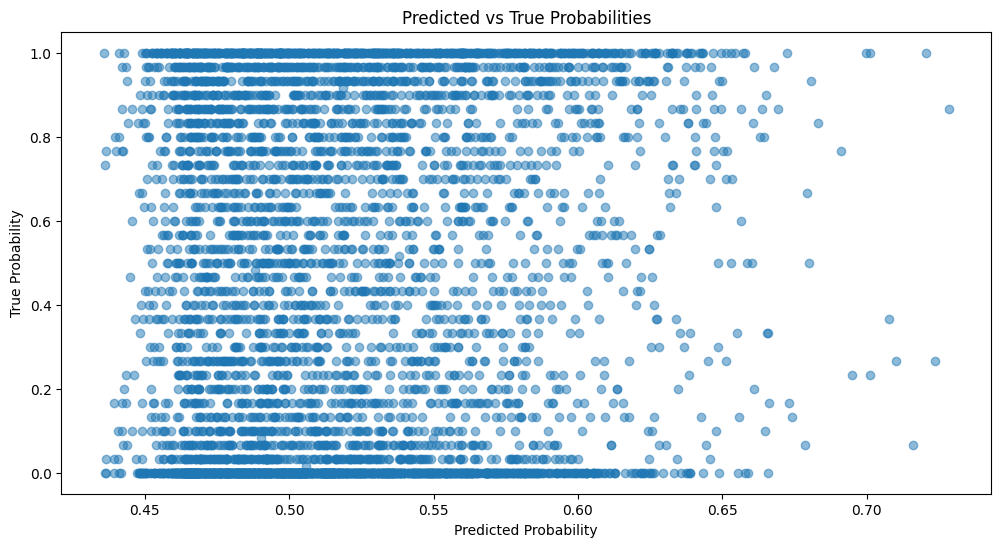

In [6]:
# plot predicted probabilities vs true probabilities.

plt.figure(figsize=(12, 6))
plt.scatter(df_test_downsamp3['predicted_prob'], df_test_downsamp3['sl'], alpha=0.5)
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Predicted vs True Probabilities")
plt.show()

/tmp/ipykernel_2171295/2072800901.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test_downsamp3.groupby("bin").agg(


bin
(0.43, 0.44]     10
(0.44, 0.45]     58
(0.45, 0.46]    174
(0.46, 0.47]    508
(0.47, 0.48]    492
(0.48, 0.49]    481
(0.49, 0.5]     481
(0.5, 0.51]     418
(0.51, 0.52]    370
(0.52, 0.53]    326
(0.53, 0.54]    321
(0.54, 0.55]    236
(0.55, 0.56]    242
(0.56, 0.57]    217
(0.57, 0.58]    163
(0.58, 0.59]    158
(0.59, 0.6]     112
(0.6, 0.61]      96
(0.61, 0.62]     62
(0.62, 0.63]     56
(0.63, 0.64]     45
(0.64, 0.65]     36
(0.65, 0.66]     19
(0.66, 0.67]     15
(0.67, 0.68]      5
(0.68, 0.69]      3
(0.69, 0.7]       3
(0.7, 0.71]       4
(0.71, 0.72]      1
(0.72, 0.73]      3
Name: count, dtype: int64


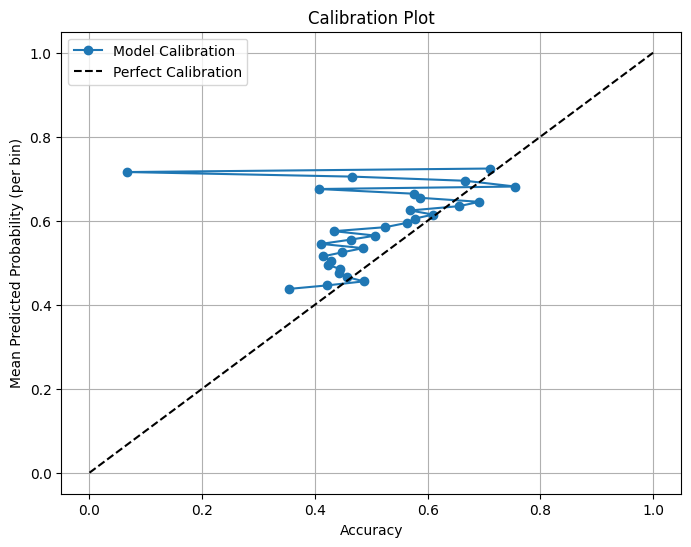

In [ ]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test_downsamp3["bin"] = pd.cut(df_test_downsamp3["predicted_prob"], bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test_downsamp3.groupby("bin").agg(
    avg_pred_prob=("predicted_prob", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()


In [28]:
downsampled_6 = sample_k_per_question(filtered_df, 6, random_state=6)
downsampled_6.shape

/tmp/ipykernel_2187454/1213052929.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), k), random_state=random_state))


(102288, 10)

In [1]:
# # create train/val/test split based on 'sb_idx' (query identifier)
# from sklearn.model_selection import train_test_split

# unique_sb_idx = downsampled_6['sb_idx'].unique()

# # Split into train and test only
# sb_idx_train, sb_idx_test = train_test_split(
#     unique_sb_idx,
#     test_size=0.10,
#     random_state=2
# )

# # Divide queries (represented by sb_idx) into train and test
# df_train_downsamp6 = downsampled_6[downsampled_6['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
# df_test_downsamp6 = downsampled_6[downsampled_6['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

# df_train_downsamp6.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv", index=False)
# df_test_downsamp6.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp6.csv", index=False)

import pandas as pd

train_downsampled_6 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv")
test_downsampled_6 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp6.csv")


In [ ]:
train_downsampled_6 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv")
test_downsampled_6 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp6.csv")

down_6_preds = np.load("/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/downsample-6-plots/softLabel_preds.npy")
test_downsampled_6['predicted_prob'] = down_6_preds

/tmp/ipykernel_1566519/2174735379.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = test_downsampled_6.groupby('bin').agg(


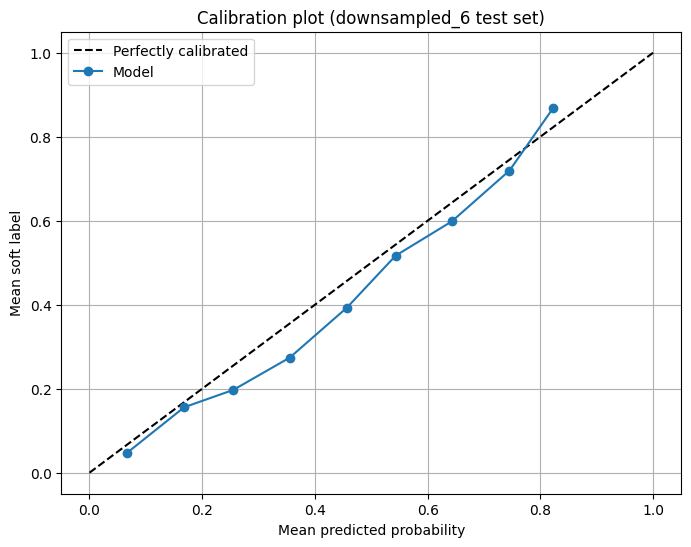

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Bin the predicted probabilities
n_bins = 10
test_downsampled_6['bin'] = pd.cut(test_downsampled_6['predicted_prob'], bins=np.linspace(0, 1, n_bins+1), include_lowest=True)

# Compute calibration: mean predicted prob vs. mean soft label in each bin
calibration = test_downsampled_6.groupby('bin').agg(
    mean_predicted_prob=('predicted_prob', 'mean'),
    mean_soft_label=('sl', 'mean'),
    count=('sl', 'size')
).reset_index()

plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.plot(calibration['mean_predicted_prob'], calibration['mean_soft_label'], marker='o', label='Model')
plt.xlabel('Mean predicted probability')
plt.ylabel('Mean soft label')
plt.title('Calibration plot (downsampled_6 test set)')
plt.legend()
plt.grid(True)
plt.show()


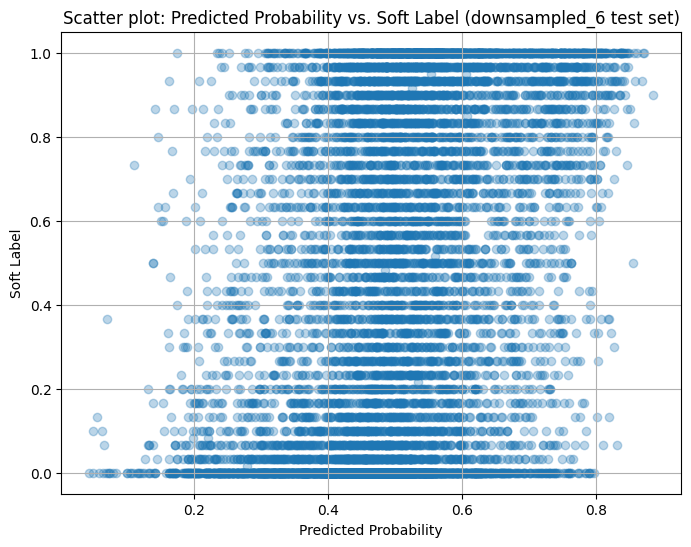

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(test_downsampled_6['predicted_prob'], test_downsampled_6['sl'], alpha=0.3)
plt.xlabel('Predicted Probability')
plt.ylabel('Soft Label')
plt.title('Scatter plot: Predicted Probability vs. Soft Label (downsampled_6 test set)')
plt.grid(True)
plt.show()


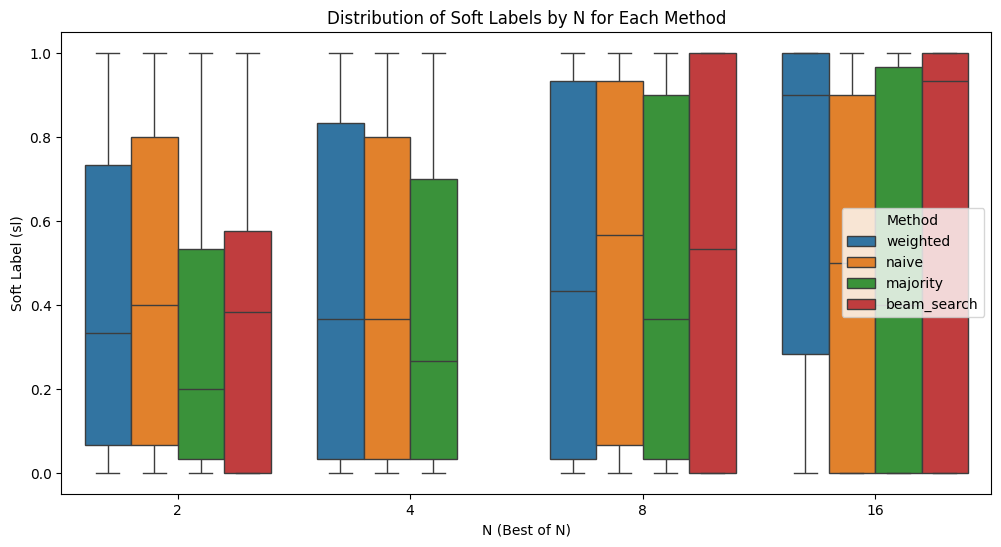

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="N", y="sl", hue="method", data=train_downsampled_6)
plt.title("Distribution of Soft Labels by N for Each Method")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.legend(title="Method")
plt.show()

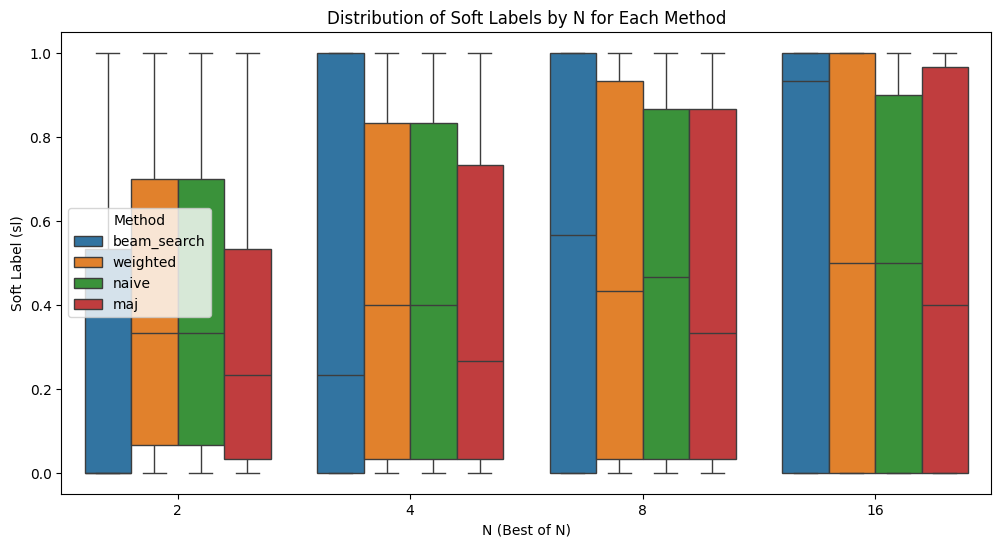

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="N", y="sl", hue="method", data=filtered_df)
plt.title("Distribution of Soft Labels by N for Each Method")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.legend(title="Method")
plt.show()

Beam_search is more varied depending on N (it goes from much lower to much higher).

In [100]:
# create train/val/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = filtered_df['sb_idx'].unique()

# Split into train and test only
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.15,
    random_state=42
)

# Divide queries (represented by sb_idx) into train and test
df_train = filtered_df[filtered_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = filtered_df[filtered_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [101]:
df_train.shape, df_test.shape

((362558, 10), (64059, 10))

START HERE: if you have df_train.

In [3]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test_29000.csv", index=False)

# read in df_train, df_val, df_test.
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/numina_5000_no_extremely_hards/df_train_numina_5000_no_extremely_hards.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/numina_5000_no_extremely_hards/df_train_numina_5000_no_extremely_hards.csv")

df_train.shape, df_test.shape

((61256, 10), (61256, 10))

In [4]:
df_train.head()

,question,N,sl,question_length,sb_idx,method_beam_search,method_majority,method_naive,method_weighted,method
0,\nA $10 \times 10$ table is filled with number...,2,0.0,451,101,True,False,False,False,beam_search
1,\nA $10 \times 10$ table is filled with number...,4,0.0,451,101,True,False,False,False,beam_search
2,\nA $10 \times 10$ table is filled with number...,8,1.0,451,101,True,False,False,False,beam_search
3,\nA $10 \times 10$ table is filled with number...,16,0.0,451,101,True,False,False,False,beam_search
4,\nA natural number \( N \) is represented as \...,2,0.0,392,332,True,False,False,False,beam_search


#### EDA: training and testing dataframes by method, N.

/tmp/ipykernel_129546/2205889479.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_129546/2205889479.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


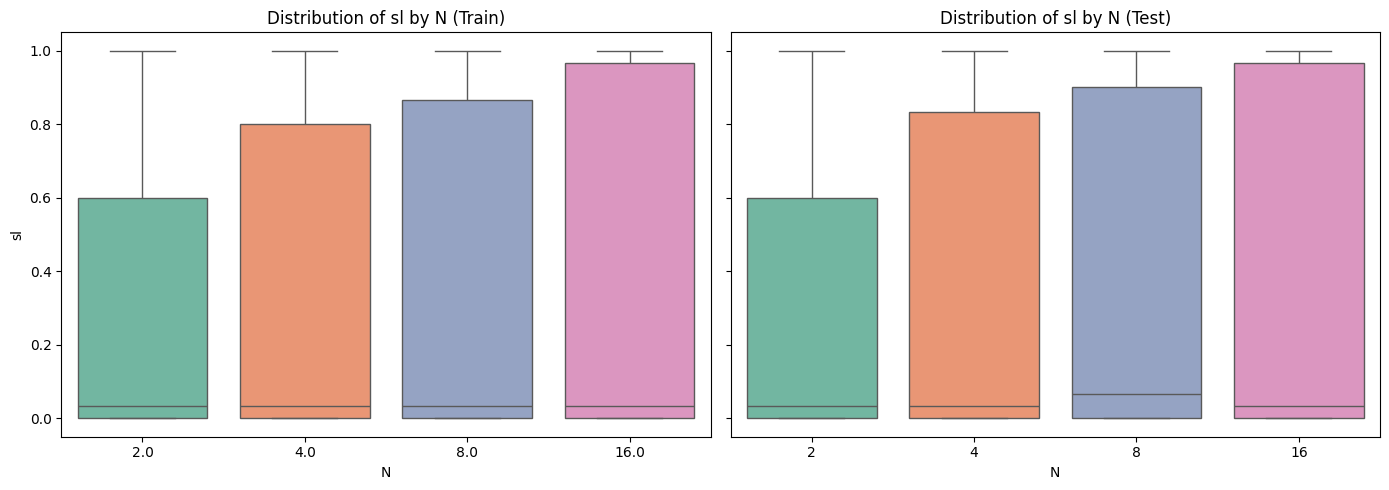

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, (df, name) in enumerate(zip([df_train, df_test], ["Train", "Test"])):
    sns.boxplot(
        x="N", y="sl", data=df, ax=axes[i], showfliers=False, palette="Set2"
    )
    axes[i].set_title(f"Distribution of sl by N ({name})")
    axes[i].set_xlabel("N")
    axes[i].set_ylabel("sl" if i == 0 else "")

plt.tight_layout()
plt.show()


/tmp/ipykernel_129546/1004913509.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_129546/1004913509.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


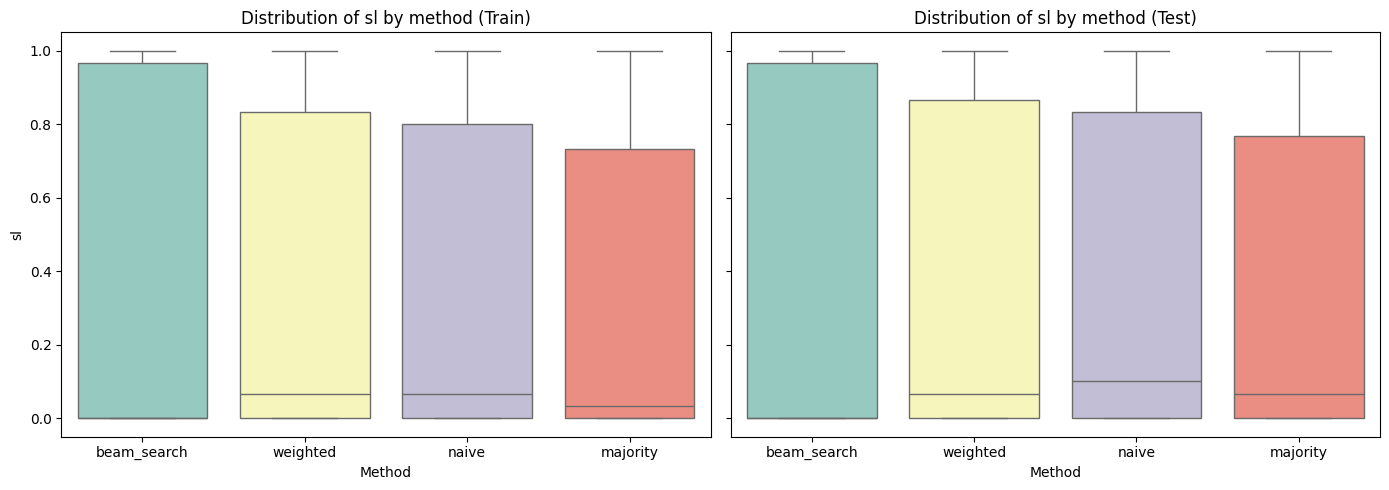

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, (df, name) in enumerate(zip([df_train, df_test], ["Train", "Test"])):
    sns.boxplot(
        x="method", y="sl", data=df, ax=axes[i], showfliers=False, palette="Set3"
    )
    axes[i].set_title(f"Distribution of sl by method ({name})")
    axes[i].set_xlabel("Method")
    axes[i].set_ylabel("sl" if i == 0 else "")

plt.tight_layout()
plt.show()


### Extract Features for Difficulty Probe.

the features are created using Python scripts in the folder labeled "features" in the "scripts" subdirectory.

In [82]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test_29000.csv", index=False)

# read in df_train, df_val, df_test.
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/df_train_16000.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/df_test_16000.csv")

df_train.shape, df_test.shape

((191341, 10), (33842, 10))

In [83]:
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693


In [84]:
X_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/train_features_BERT_pca_32.npy")
y_train = df_train["sl"].values.astype(float)

In [85]:
X_val = np.load("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/val_features_BERT_pca_32.npy")
y_val = df_test["sl"].values.astype(float)


In [86]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((191341, 38), (191341,), (33842, 38), (33842,))

### Load in Training/Testing Data

### Train MLP.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [88]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [89]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape # old ((37440, 1542), (37440,), (6624, 1542), (6624,))

((191341, 38), (191341,), (33842, 38), (33842,))

### Create Custom MLP

In [90]:
import torch
import torch.nn as nn                       
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [91]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. MLP Model - following from the LLM Routing Paper. -----
# Add one repetition of the auxiliary features (last 6 dims) as extra input into each layer

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim,16),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Linear(16, 4),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=38)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [92]:
# ----- 6. Training Loop -----
num_epochs = 5
batch_size = 128    # Batch size of 128

agg_train_loss = []
agg_val_loss = []
step_train_loss = []
step_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0
counter = 0 
train_steps,val_steps = [],[]

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    for i, (batch_X, batch_y) in enumerate(train_loader):
        counter += 1
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_steps.append(counter)
        train_loss.append(loss.item())
        step_train_loss.append(loss.item())
        if (i + 1) % 100 == 0:
            model.eval()
            val_loss_step = []
            with torch.no_grad():
                for val_X, val_y in val_loader:
                    val_preds = model(val_X)
                    val_loss_step.append(criterion(val_preds, val_y).item())
            mean_val_loss_step = np.mean(val_loss_step)
            step_val_loss.append(mean_val_loss_step)
            val_steps.append(counter)
            print(f"Epoch {epoch+1}, Step {i+1}, Train Loss: {loss.item():.4f}, Val Loss: {mean_val_loss_step:.4f}")
            model.train()


Epoch 1, Step 100, Train Loss: 0.6977, Val Loss: 0.7063
Epoch 1, Step 200, Train Loss: 0.6684, Val Loss: 0.7009
Epoch 1, Step 300, Train Loss: 0.6195, Val Loss: 0.6956
Epoch 1, Step 400, Train Loss: 0.6850, Val Loss: 0.6924
Epoch 1, Step 500, Train Loss: 0.7115, Val Loss: 0.6892
Epoch 1, Step 600, Train Loss: 0.6984, Val Loss: 0.6868
Epoch 1, Step 700, Train Loss: 0.6746, Val Loss: 0.6846
Epoch 1, Step 800, Train Loss: 0.6964, Val Loss: 0.6814
Epoch 1, Step 900, Train Loss: 0.6549, Val Loss: 0.6785
Epoch 1, Step 1000, Train Loss: 0.6747, Val Loss: 0.6768
Epoch 1, Step 1100, Train Loss: 0.6688, Val Loss: 0.6738
Epoch 1, Step 1200, Train Loss: 0.6716, Val Loss: 0.6719
Epoch 1, Step 1300, Train Loss: 0.6787, Val Loss: 0.6700
Epoch 1, Step 1400, Train Loss: 0.6775, Val Loss: 0.6685
Epoch 1, Step 1500, Train Loss: 0.6784, Val Loss: 0.6661
Epoch 1, Step 1600, Train Loss: 0.6212, Val Loss: 0.6638
Epoch 1, Step 1700, Train Loss: 0.6522, Val Loss: 0.6631
Epoch 1, Step 1800, Train Loss: 0.6955, 

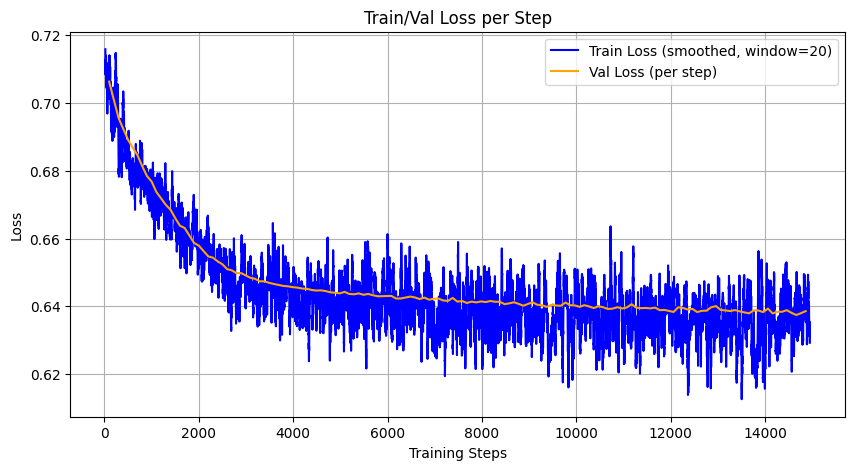

In [93]:
# ----- 7. Plot Training and Validation Loss (per step) -----
import matplotlib.pyplot as plt
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.figure(figsize=(10, 5))
window = 20  # tweak as needed
smoothed_train_loss = moving_average(step_train_loss, window)
smoothed_train_steps = train_steps[window-1:] if len(train_steps) == len(step_train_loss) else np.arange(len(smoothed_train_loss))
plt.plot(smoothed_train_steps, smoothed_train_loss, label=f'Train Loss (smoothed, window={window})', color='blue')
plt.plot(val_steps, step_val_loss, label='Val Loss (per step)', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Step')
plt.legend()
plt.grid(True)
plt.show()

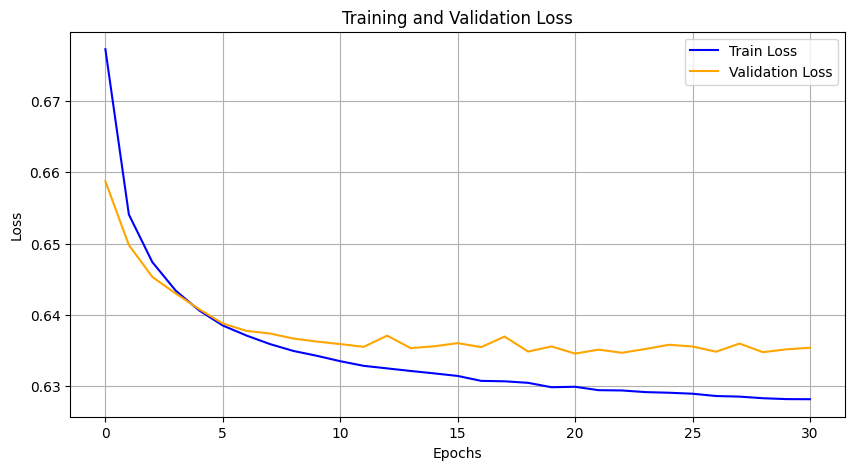

In [28]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Make Predictions on Test.

In [94]:
X_val.shape

(33842, 38)

In [95]:
model.eval()
X_test_tensor = torch.tensor(X_val, dtype=torch.float32)

with torch.no_grad():
    softLabel_Preds = model(X_test_tensor)

softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
softLabel_preds_numpy

array([0.34680417, 0.5928414 , 0.22171135, ..., 0.79253477, 0.79794794,
       0.72975534], dtype=float32)

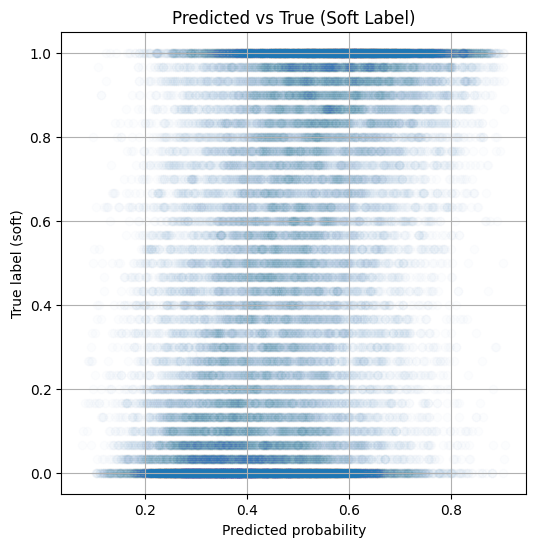

In [96]:
plt.figure(figsize=(6, 6)) # the probe is being conservative in predicting extreme values.
# look at targets for training.
# after every validation loss, plot a calibration chart... after each epoch...
plt.scatter(softLabel_preds_numpy, y_val, alpha=1e-2)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

In [97]:
df_test['predicted_prob'] = softLabel_preds_numpy

AUC: 0.7202


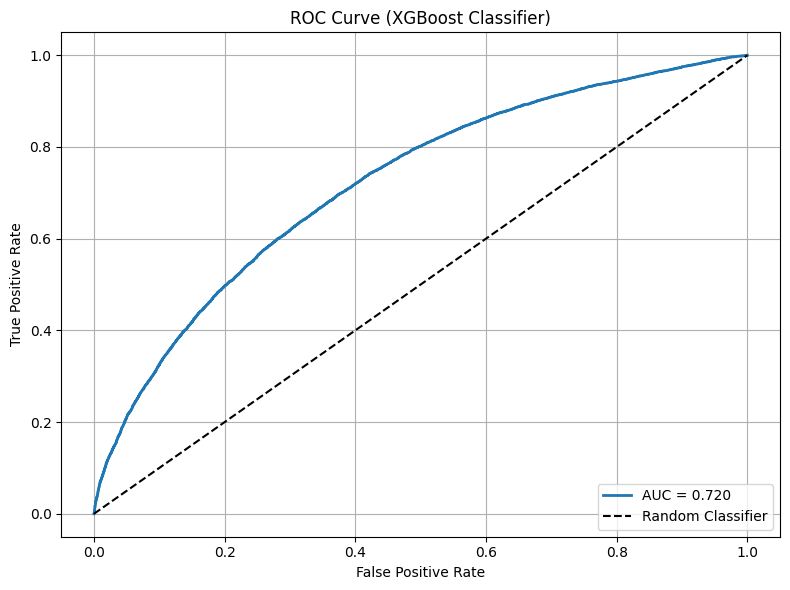

In [98]:
### Train XGBoost Classifier
y_test_binary = y_val > 0.5
from sklearn.metrics import roc_auc_score
# Compute AUC
auc = roc_auc_score(y_test_binary, softLabel_preds_numpy)
print(f"AUC: {auc:.4f}")
# AUC with all features.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, softLabel_preds_numpy)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

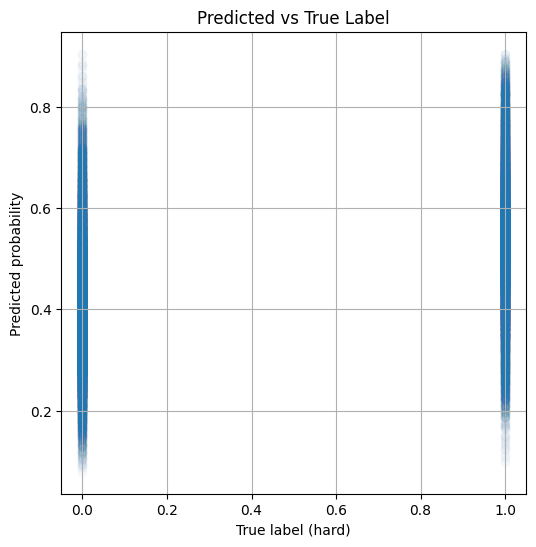

In [99]:
import matplotlib.pyplot as plt
# the XGBoost model does slightly better in outputting predicted probabilities.
plt.figure(figsize=(6, 6))
plt.scatter(y_test_binary, softLabel_preds_numpy, alpha=1e-2)
plt.xlabel("True label (hard)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True Label")
plt.grid(True)
plt.show()

In [ ]:
# df_train['predicted_prob'] = hardLabel_preds_numpy
# df_test['predicted_prob'] = hardLabel_preds_numpy # PyTorch MLP predictions from hard label.
# df_train['predicted_prob'] = y_proba_train # sklearn MLPClassifier predictions (hard label version)

In [100]:
# there should be 23 different BoN configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,15
1,7,14
2,17,15
3,25,15
4,35,14
...,...,...
2366,15786,14
2367,15795,12
2368,15797,12
2369,15798,15


Add token counts for parallel methods and for beam.

In [ ]:
# created using concatenate_completions.py.
bon_token_counts = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/bon_token_counts_16000.csv')
bon_token_counts = bon_token_counts.rename(columns={"problem": "question"})
bon_token_counts.head()

,question,completion_tokens
0,Through the midpoint \(M\) of side \(BC\) of p...,"[456, 379, 547, 438, 475, 981, 397, 459, 590, ..."
1,Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...,"[513, 2048, 524, 614, 507, 545, 531, 575, 717,..."
2,"Let $a,$ $b,$ $c$ be positive real numbers suc...","[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
3,Given that the graph of the quadratic function...,"[1016, 731, 886, 1084, 828, 682, 822, 863, 837..."
4,"Three circles $\mathcal{K}_1$ , $\mathcal{K}...","[620, 629, 706, 678, 703, 573, 516, 641, 831, ..."


In [102]:
df_test = df_test.merge(bon_token_counts, on="question", how="left")
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,predicted_prob,completion_tokens
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432,0.346804,"[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858,0.592841,"[16, 174, 166, 141, 158, 166, 16, 136, 150, 64..."
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298,0.221711,"[408, 997, 562, 1237, 1689, 724, 801, 1042, 10..."
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845,0.404806,"[305, 502, 526, 531, 455, 220, 470, 280, 389, ..."
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693,0.533797,"[247, 337, 281, 290, 314, 326, 289, 271, 305, ..."


### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [ ]:
# train_downsampled_6 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv")
# test_downsampled_6 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp6.csv")

# down_6_preds = np.load("/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/downsample-6-plots/softLabel_preds.npy")
# test_downsampled_6['predicted_prob'] = down_6_preds

In [ ]:
# test_downsampled_6.head()

df_test = df_test.merge(bon_token_counts, on="question", how="left")
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,predicted_prob,completion_tokens
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432,0.346804,"[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858,0.592841,"[16, 174, 166, 141, 158, 166, 16, 136, 150, 64..."
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298,0.221711,"[408, 997, 562, 1237, 1689, 724, 801, 1042, 10..."
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845,0.404806,"[305, 502, 526, 531, 455, 220, 470, 280, 389, ..."
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693,0.533797,"[247, 337, 281, 290, 314, 326, 289, 271, 305, ..."


In [110]:
# # compute token counts.
# # First turn completion tokens into a list of ints.
df_test["completion_tokens"] = df_test["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Then obtain Token Count for Best of N.
df_test["token_count"] = df_test.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)

In [111]:
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,predicted_prob,completion_tokens,token_count
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432,0.346804,"[1285, 990, 883, 698, 749, 400, 877, 1020, 620...",2275
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858,0.592841,"[16, 174, 166, 141, 158, 166, 16, 136, 150, 64...",190
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298,0.221711,"[408, 997, 562, 1237, 1689, 724, 801, 1042, 10...",1405
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845,0.404806,"[305, 502, 526, 531, 455, 220, 470, 280, 389, ...",807
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693,0.533797,"[247, 337, 281, 290, 314, 326, 289, 271, 305, ...",584


In [152]:
# filter out all rows that are beam.
df_test_no_beam = df_test[df_test["method"] != "beam_search"]

In [189]:
def compute_max_utility_pred(df, lambda_):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        group["utility"] = group["sl"] - lambda_ * group["token_count"]
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            # "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [215]:
# Sweep over lambda values
lambda_list = np.logspace(-50, -1, num=200) 

In [216]:
results = []

for lambda_value in lambda_list:
    adaptive_router = compute_max_utility_pred(df_test_no_beam, lambda_value)
    average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    # average_time = adaptive_router["max_time"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
    
    results.append({
        "lambda": lambda_value,
        "sl": average_accuracy,
        "token_count": average_cost,
        "predicted_prob": average_predicted_prob,
        # "time": average_time,
    })

# Convert to DataFrame
query_adaptive_df = pd.DataFrame(results)
# oracle_df = pd.DataFrame(results)

/tmp/ipykernel_1566519/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1566519/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1566519/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping colum

In [212]:
query_adaptive_df["method"] = "adaptive"
query_adaptive_df.head()
# oracle_df['method'] = 'oracle'
# oracle_df.head()

,lambda,sl,token_count,predicted_prob,method
0,1.000000e-50,0.627752,5141.278785,0.500069,adaptive
1,1.762914e-50,0.627752,5141.278785,0.500069,adaptive
2,3.107866e-50,0.627752,5141.278785,0.500069,adaptive
3,5.478901e-50,0.627752,5141.278785,0.500069,adaptive
4,9.658832e-50,0.627752,5141.278785,0.500069,adaptive


In [ ]:
# query_adaptive_df_short = query_adaptive_df[query_adaptive_df["lambda"] > 1e-6]
# query_adaptive_df_short.head()

,lambda,sl,token_count,predicted_prob,method
179,0.000001,0.627752,5139.448756,0.500068,adaptive
180,0.000002,0.627724,5122.669760,0.499981,adaptive
181,0.000004,0.627450,5031.850696,0.499726,adaptive
182,0.000007,0.625777,4701.867988,0.498390,adaptive
183,0.000011,0.621412,4219.275411,0.495238,adaptive


In [214]:
# rename column indicator to accuracy.
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test_no_beam.groupby(["N", "method"])[
    ["sl", "predicted_prob", "token_count"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

config_summary_df.tail()

,N,method,sl,predicted_prob,token_count
7,8,naive,0.515481,0.521674,4467.261438
8,8,weighted,0.519409,0.520134,4467.261438
9,16,majority,0.511605,0.525516,8957.807382
10,16,naive,0.530386,0.527555,8957.807382
11,16,weighted,0.546892,0.544205,8957.807382


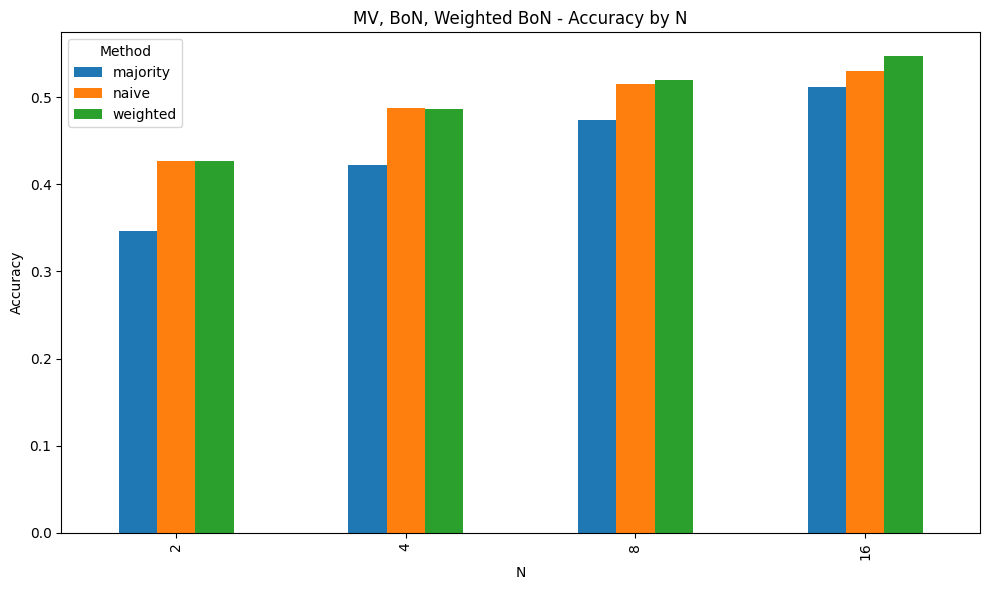

In [203]:
### TESTING DF
# Pivot for plotting
pivot_df = config_summary_df.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

In [204]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    config_summary_df,
    on=["sl", "token_count", "method", "predicted_prob"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [205]:
query_optimal_static_df.head()

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000000,0.345893,1124.248750,0.383979,majority,2.0
1,-1.000000,0.422133,2230.561707,0.422240,majority,4.0
2,0.003331,0.424624,1109.649515,0.448703,adaptive,-1.0
3,0.005873,0.424624,1109.649515,0.448703,adaptive,-1.0
4,0.010353,0.424624,1109.649515,0.448703,adaptive,-1.0


Join the Oracle.

In [206]:
query_optimal_static_df = pd.merge(
    query_optimal_static_df,
    oracle_df,
    on=["lambda", "sl", "token_count", "predicted_prob", "method"],
    how="outer"
)

In [207]:
# Replace NaN values with -1 for plotting purposes
query_optimal_static_df = query_optimal_static_df.fillna(-1)

# Display the merged DataFrame
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000000,0.345893,1124.248750,0.383979,majority,2.0
1,-1.000000,0.422133,2230.561707,0.422240,majority,4.0
2,-1.000000,0.426195,1124.248750,0.443457,naive,2.0
3,-1.000000,0.426195,1124.248750,0.444780,weighted,2.0
4,-1.000000,0.473440,4467.261438,0.485091,majority,8.0
...,...,...,...,...,...,...
216,0.032176,0.433875,1109.649515,0.434625,oracle,-1.0
217,0.056724,0.424624,1109.649515,0.448703,adaptive,-1.0
218,0.056724,0.433875,1109.649515,0.434625,oracle,-1.0
219,0.100000,0.424624,1109.649515,0.448703,adaptive,-1.0


In [208]:
# arrange in descending order of sl.
query_optimal_static_df.sort_values(by="sl", ascending=True).tail

<bound method NDFrame.tail of            lambda        sl  token_count  predicted_prob    method    N
0   -1.000000e+00  0.345893  1124.248750        0.383979  majority  2.0
1   -1.000000e+00  0.422133  2230.561707        0.422240  majority  4.0
217  5.672426e-02  0.424624  1109.649515        0.448703  adaptive -1.0
215  3.217642e-02  0.424624  1109.649515        0.448703  adaptive -1.0
213  1.825183e-02  0.424624  1109.649515        0.448703  adaptive -1.0
..            ...       ...          ...             ...       ...  ...
87   2.933166e-32  0.627752  5141.278785        0.500069    oracle -1.0
88   5.170920e-32  0.627752  5141.278785        0.500069    oracle -1.0
89   9.115888e-32  0.627752  5141.278785        0.500069    oracle -1.0
79   3.144035e-34  0.627752  5141.278785        0.500069    oracle -1.0
110  1.350994e-26  0.627752  5141.278785        0.500069    oracle -1.0

[221 rows x 6 columns]>

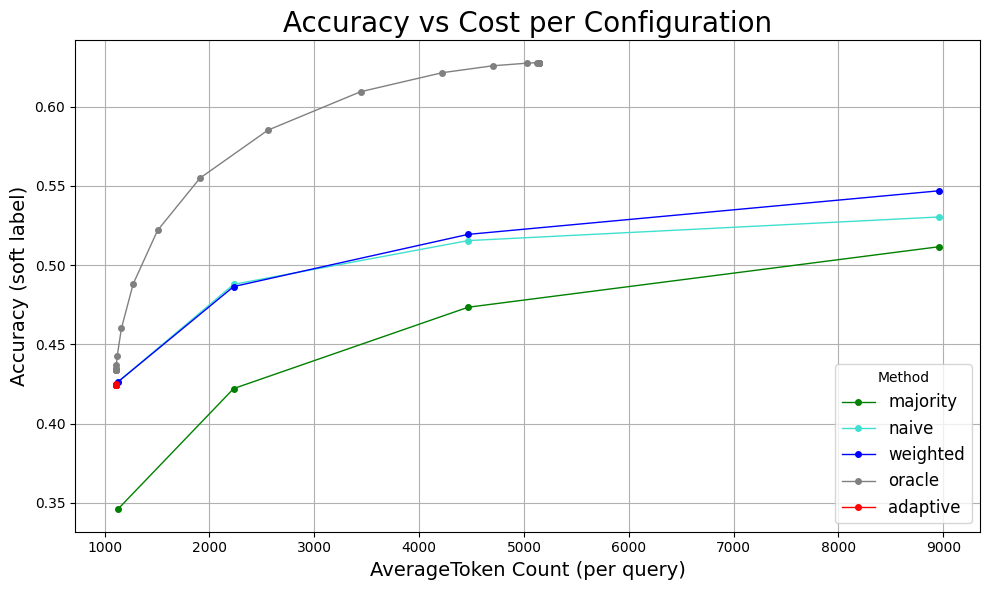

In [209]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    if method != "beam_search":
        method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
        color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
        plt.plot(
            method_df["token_count"], 
            method_df["sl"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

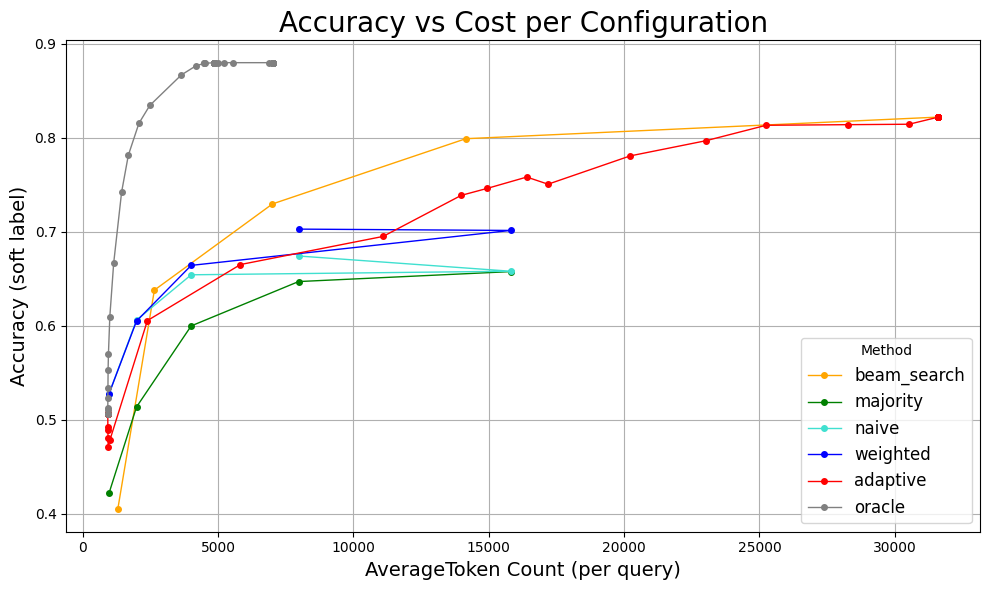

In [ ]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


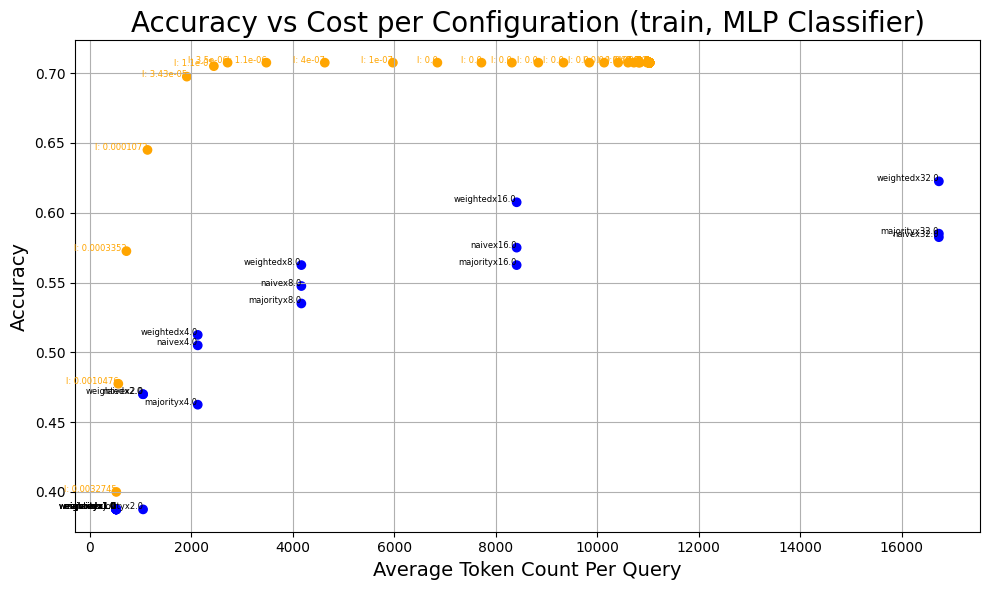

In [ ]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, MLP Classifier)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'qa', 'qa', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'qa', 'weightedx8.0', 'majorityx16.0', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


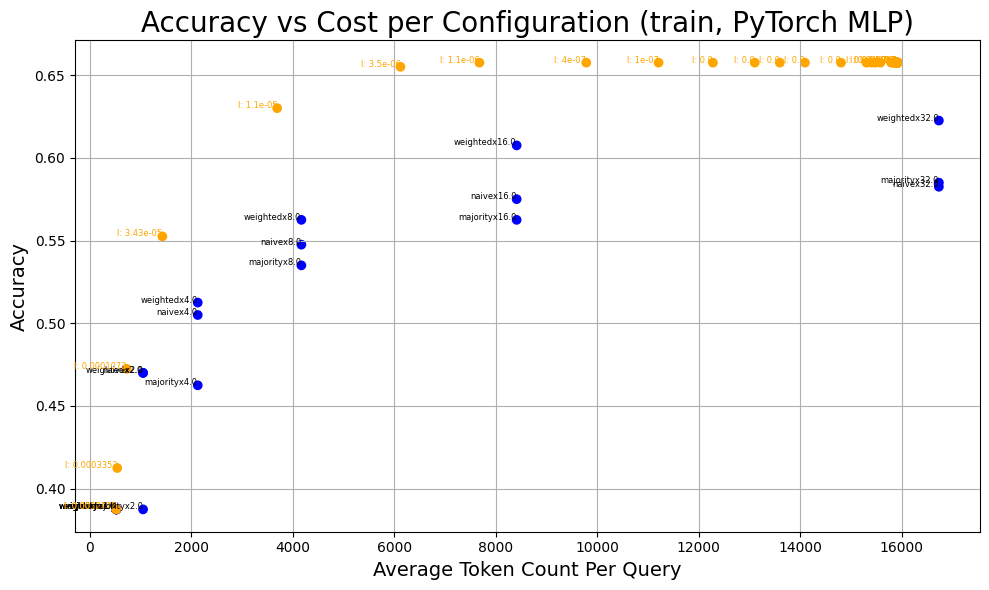

In [ ]:
# Create color labels and text labels (pyTorch MLP)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, PyTorch MLP)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


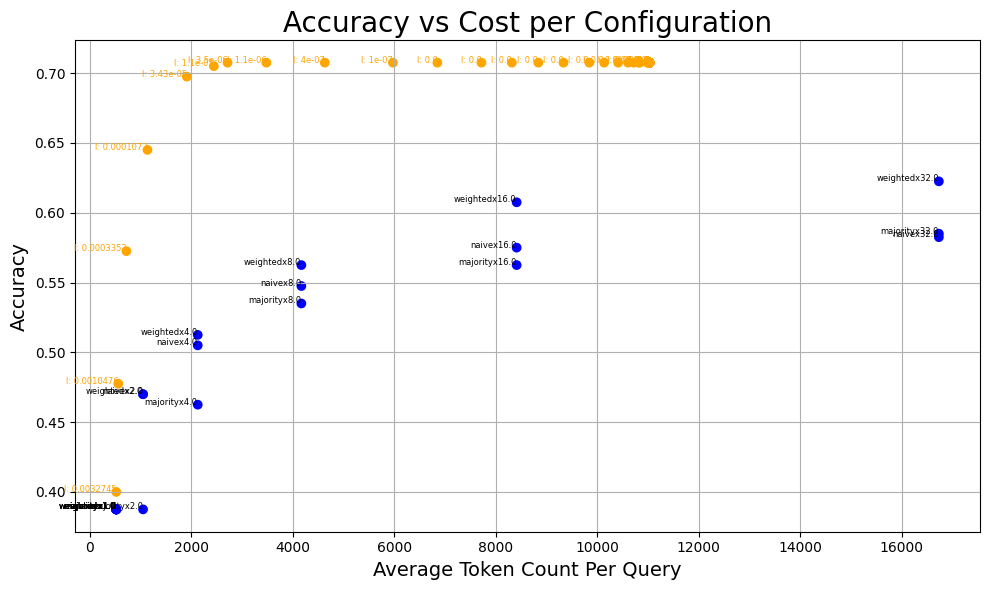

In [ ]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).